In [1]:
!pip install pandas scikit-learn numpy requests matplotlib joblib


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta
from time import sleep
import joblib 
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# --- КОНФИГУРАЦИЯ ---
MODEL_FILENAME = "baseline_model.joblib"
TARGET_HORIZON = 3      # Прогноз на 3 часа вперед
REQUESTS_COUNT = 10     # Количество запросов к API (10 * 1000 = 10 000 часов данных)

# КОНФИГУРАЦИЯ API (Bybit)
BYBIT_URL = "https://api.bybit.com/v5/market/kline"
SYMBOL = "BTCUSDT"
INTERVAL = "60"         # 1 час
LIMIT = 1000            # Максимальное количество баров за запрос (для Bybit V5)

# --- МЕТРИКА ---
def mean_absolute_percentage_error(y_true, y_pred):
    """Рассчитывает метрику MAPE (Mean Absolute Percentage Error)."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

In [3]:
# --- ФУНКЦИИ СБОРА ДАННЫХ ---

def fetch_kline_data(end_timestamp_ms: int):
    """Выполняет один запрос к Bybit API и возвращает список данных."""
    params = {
        'category': 'linear', 
        'symbol': SYMBOL,
        'interval': INTERVAL,
        'limit': LIMIT,
        'end': end_timestamp_ms 
    }
    
    try:
        response = requests.get(BYBIT_URL, params=params, timeout=10)
        response.raise_for_status()
        # API Bybit возвращает ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'turnover']
        return response.json()['result']['list']
    except Exception as e:
        print(f"Ошибка при запросе к Bybit API: {e}")
        return []

def run_data_fetcher():
    """Собирает исторические данные с Bybit API, обрабатывает и возвращает DataFrame."""
    end_time = datetime.now()
    end_timestamp_ms = int(end_time.timestamp() * 1000)
    all_raw_data = []

    print(f"Начало сбора {REQUESTS_COUNT} блоков данных (до {REQUESTS_COUNT * LIMIT} часов)...")
    
    for i in range(REQUESTS_COUNT):
        current_time = datetime.fromtimestamp(end_timestamp_ms / 1000).strftime('%Y-%m-%d %H:%M')
        print(f"  > Запрос {i+1}/{REQUESTS_COUNT}. Конечная точка: {current_time}")
        
        raw_data_block = fetch_kline_data(end_timestamp_ms)
        
        if not raw_data_block:
            print("Нет данных. Пагинация остановлена.")
            break
            
        all_raw_data.extend(raw_data_block)
        
        # Обновляем 'end' для следующего запроса (самый старый бар в текущем блоке)
        end_timestamp_ms = int(raw_data_block[-1][0])
        sleep(0.5) 
    
    if not all_raw_data:
        print("Сбор данных не удался. Завершение.")
        return pd.DataFrame()

    # 4. Преобразование данных
    df = pd.DataFrame(
        all_raw_data,
        columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'turnover']
    )
    if 'turnover' in df.columns:
        df = df.drop(columns=['turnover'])
    
    df['timestamp'] = pd.to_datetime(df['timestamp'].astype(int), unit='ms')
    cols_to_convert = ['open', 'high', 'low', 'close', 'volume']
    df[cols_to_convert] = df[cols_to_convert].astype(float)
    
    # Индексируем по времени и удаляем дубликаты
    df = df.drop_duplicates(subset=['timestamp']).set_index('timestamp').sort_index()
    
    print(f"\n--- СБОР ДАННЫХ ЗАВЕРШЕН ---")
    print(f"Уникальных баров собрано: {len(df)}")
    return df


# --- ЗАПУСК СБОРА ---
raw_data_df = run_data_fetcher()

if not raw_data_df.empty:
    print("\nПервые 5 строк собранных данных:")
    display(raw_data_df.head())

Начало сбора 10 блоков данных (до 10000 часов)...
  > Запрос 1/10. Конечная точка: 2025-10-07 17:49
  > Запрос 2/10. Конечная точка: 2025-08-27 02:00
  > Запрос 3/10. Конечная точка: 2025-07-16 11:00
  > Запрос 4/10. Конечная точка: 2025-06-04 20:00
  > Запрос 5/10. Конечная точка: 2025-04-24 05:00
  > Запрос 6/10. Конечная точка: 2025-03-13 14:00
  > Запрос 7/10. Конечная точка: 2025-01-30 23:00
  > Запрос 8/10. Конечная точка: 2024-12-20 08:00
  > Запрос 9/10. Конечная точка: 2024-11-08 17:00
  > Запрос 10/10. Конечная точка: 2024-09-28 02:00

--- СБОР ДАННЫХ ЗАВЕРШЕН ---
Уникальных баров собрано: 9991

Первые 5 строк собранных данных:


,open,high,low,close,volume
timestamp,,,,,
2024-08-17 08:00:00,59223.7,59270.0,59134.2,59257.9,1014.774
2024-08-17 09:00:00,59257.9,59458.0,59184.0,59295.6,2206.915
2024-08-17 10:00:00,59295.6,59320.0,59050.0,59085.9,2083.569
2024-08-17 11:00:00,59085.9,59206.0,59034.9,59106.3,1852.625
2024-08-17 12:00:00,59106.3,59250.5,59068.0,59206.0,1158.929


In [13]:
# --- ФУНКЦИИ ПОДГОТОВКИ ДАННЫХ И ОБУЧЕНИЯ ---

def create_features_and_target(df: pd.DataFrame):
    """Создает целевую переменную (Y) и признаки (X)."""
    
    # 1. Целевая Переменная (Y): Цена закрытия через TARGET_HORIZON часов
    df['target'] = df['close'].shift(-TARGET_HORIZON)
    
    # 2. Признаки (X) - Baseline
    df['lag_1h'] = df['close'].shift(1)
    df['lag_2h'] = df['close'].shift(2)
    df['lag_24h'] = df['close'].shift(24)
    df['SMA_10h'] = df['close'].rolling(window=10).mean()
    df['price_change_1h'] = df['close'] - df['close'].shift(1)

    # 3. Очистка и определение X, Y
    df_clean = df.dropna()
    features = ['lag_1h', 'lag_2h', 'lag_24h', 'SMA_10h', 'price_change_1h']
    X = df_clean[features]
    Y = df_clean['target']
    
    return X, Y


def train_and_save_model(X, Y):
    """Обучает Линейную Регрессию, оценивает и сохраняет модель."""
    
    # Разбиение данных: Последние 20% - это валидационная/тестовая выборка (shuffle=False!)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)
    
    print(f"\nДанные для обучения: {len(X_train)} строк.")
    print(f"Данные для валидации: {len(X_test)} строк.")
    
    # 1. Обучение модели
    model = LinearRegression()
    model.fit(X_train, Y_train)
    
    # 2. Прогноз и Оценка
    Y_pred = model.predict(X_test)

    r2 = r2_score(Y_test, Y_pred)
    mape = mean_absolute_percentage_error(Y_test, Y_pred) 
    
    print("-" * 40)
    print("РЕЗУЛЬТАТЫ ОЦЕНКИ БАЗОВОЙ МОДЕЛИ:")
    print(f"Коэффициент детерминации (R^2): {r2:.4f}")
    print(f"Средняя абсолютная процентная ошибка (MAPE): {mape:.2f}%")
    print("-" * 40)
    
    # 3. Сохранение модели
    joblib.dump(model, MODEL_FILENAME)
    print(f"Модель сохранена как {MODEL_FILENAME}")
    
    return Y_test, Y_pred

# --- ЗАПУСК ОБУЧЕНИЯ ---
if not raw_data_df.empty:
    X, Y = create_features_and_target(raw_data_df)
    if not X.empty:
        Y_test_data, Y_pred_data = train_and_save_model(X, Y)
    else:
        print("Ошибка: X или Y пусты после создания признаков.")
else:
    print("Обучение пропущено, так как данные не были загружены.")


Данные для обучения: 7971 строк.
Данные для валидации: 1993 строк.
----------------------------------------
РЕЗУЛЬТАТЫ ОЦЕНКИ БАЗОВОЙ МОДЕЛИ:
Коэффициент детерминации (R^2): 0.9716
Средняя абсолютная процентная ошибка (MAPE): 0.38%
----------------------------------------
Модель сохранена как baseline_model.joblib


<>:51: SyntaxWarning: invalid escape sequence '\h'
<>:52: SyntaxWarning: invalid escape sequence '\e'
<>:51: SyntaxWarning: invalid escape sequence '\h'
<>:52: SyntaxWarning: invalid escape sequence '\e'
C:\Users\Farit\AppData\Local\Temp\ipykernel_17776\4269547865.py:51: SyntaxWarning: invalid escape sequence '\h'
  plt.xlabel('Прогнозируемые Значения ($\hat{Y}$)')
C:\Users\Farit\AppData\Local\Temp\ipykernel_17776\4269547865.py:52: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel('Остатки ($\epsilon$ = Y - $\hat{Y}$)')


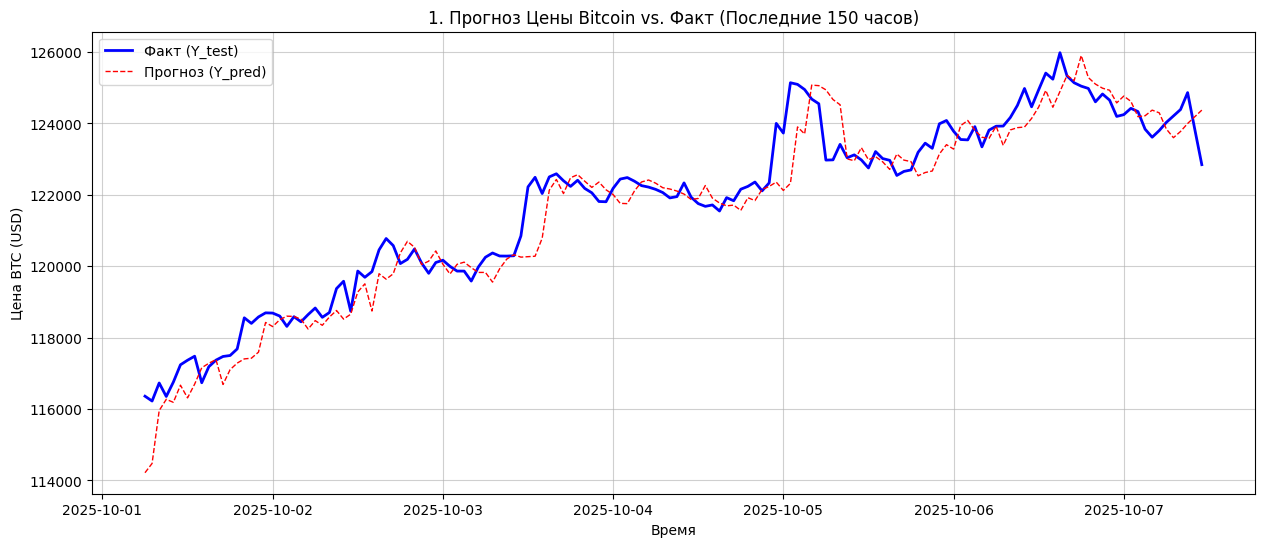

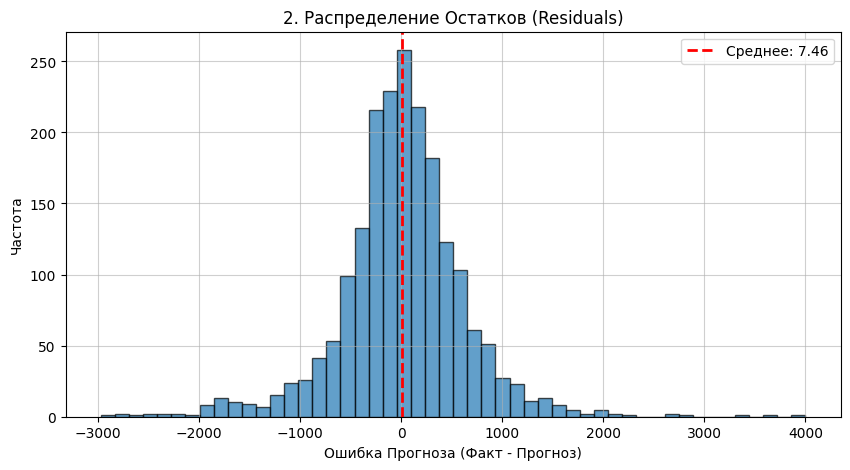

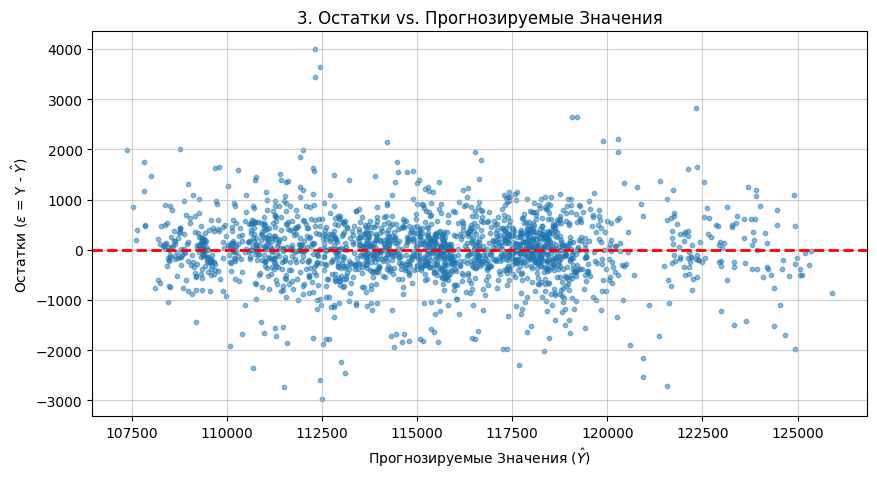

In [14]:
# --- ФУНКЦИИ ВИЗУАЛИЗАЦИИ ---

def plot_model_diagnostics(Y_test, Y_pred):
    """Строит три графика: Прогноз vs Факт, Гистограмма Остатков, Диаграмма Рассеяния Остатков."""
    
    # Остатки
    residuals = Y_test - Y_pred

    # ----------------------------------------
    # 1. Прогноз vs. Факт (Zoom на последних 150 точках)
    # ----------------------------------------
    plt.figure(figsize=(15, 6))
    N = 150 # Последние 150 наблюдений
    Y_test_subset = Y_test.tail(N)
    Y_pred_subset = Y_pred[-N:]
    time_index = Y_test_subset.index
    
    plt.plot(time_index, Y_test_subset, label='Факт (Y_test)', color='blue', linewidth=2)
    plt.plot(time_index, Y_pred_subset, label='Прогноз (Y_pred)', color='red', linestyle='--', linewidth=1)
    
    plt.title(f'1. Прогноз Цены Bitcoin vs. Факт (Последние {N} часов)')
    plt.xlabel('Время')
    plt.ylabel('Цена BTC (USD)')
    plt.legend()
    plt.grid(True, alpha=0.6)
    plt.show()

    # ----------------------------------------
    # 2. Гистограмма Остатков (Проверка Нормальности)
    # ----------------------------------------
    plt.figure(figsize=(10, 5))
    plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
    mean_res = np.mean(residuals)
    plt.axvline(mean_res, color='red', linestyle='dashed', linewidth=2, label=f'Среднее: {mean_res:.2f}')
    
    plt.title('2. Распределение Остатков (Residuals)')
    plt.xlabel('Ошибка Прогноза (Факт - Прогноз)')
    plt.ylabel('Частота')
    plt.legend()
    plt.grid(True, alpha=0.6)
    plt.show()
    
    # ----------------------------------------
    # 3. Диаграмма Рассеяния Остатков (Проверка Гомоскедастичности)
    # ----------------------------------------
    plt.figure(figsize=(10, 5))
    plt.scatter(Y_pred, residuals, alpha=0.5, s=10)
    plt.axhline(0, color='red', linestyle='--', linewidth=2)
    
    plt.title('3. Остатки vs. Прогнозируемые Значения')
    plt.xlabel('Прогнозируемые Значения ($\hat{Y}$)')
    plt.ylabel('Остатки ($\epsilon$ = Y - $\hat{Y}$)')
    plt.grid(True, alpha=0.6)
    plt.show()

# --- ЗАПУСК ВИЗУАЛИЗАЦИИ ---
if 'Y_test_data' in locals():
    plot_model_diagnostics(Y_test_data, Y_pred_data)
else:
    print("Визуализация пропущена, так как обучение не было завершено.")

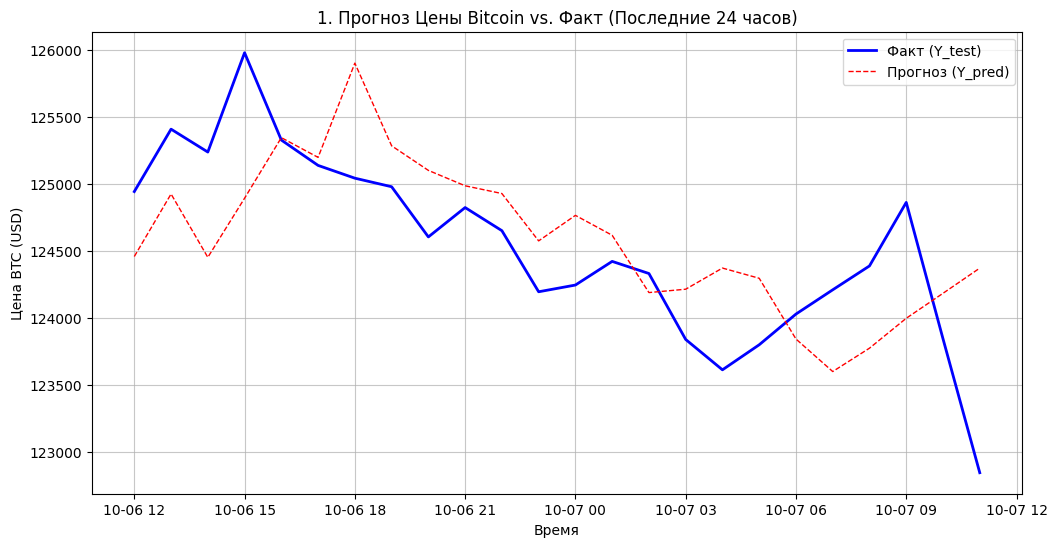

MAPE для последних 24 часов: 0.4028%


In [15]:
import matplotlib.pyplot as plt

# Предполагается, что Y_test_data и Y_pred_data содержат результаты первой модели (прогноз абсолютной цены)

if 'Y_test_data' in locals():
    
    # Устанавливаем N=24 для отображения последних 24 часов
    N = 24 
    Y_test_subset = Y_test_data.tail(N)
    # Важно: Y_pred_data — это NumPy массив, нужно взять последние N элементов
    Y_pred_subset = Y_pred_data[-N:]
    
    time_index = Y_test_subset.index
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(time_index, Y_test_subset, label='Факт (Y_test)', color='blue', linewidth=2)
    plt.plot(time_index, Y_pred_subset, label='Прогноз (Y_pred)', color='red', linestyle='--', linewidth=1)
    
    plt.title(f'1. Прогноз Цены Bitcoin vs. Факт (Последние {N} часов)')
    plt.xlabel('Время')
    plt.ylabel('Цена BTC (USD)')
    plt.legend()
    plt.grid(True, alpha=0.7)
    plt.show()

    # Рассчитаем и выведем MAPE только для этого 24-часового отрезка (для сравнения)
    # MAPE для подмножества данных
    mape_subset = np.mean(np.abs((Y_test_subset.values - Y_pred_subset) / Y_test_subset.values)) * 100
    print(f"MAPE для последних {N} часов: {mape_subset:.4f}%")
    
else:
    print("Переменные Y_test_data и Y_pred_data не найдены. Сначала запустите обучение первой модели.")

In [6]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta
from time import sleep
import joblib 
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score, confusion_matrix # <-- Новый импорт для Accuracy

# --- КОНФИГУРАЦИЯ ---
MODEL_FILENAME = "baseline_model_return.joblib" # Сменили имя файла, т.к. модель теперь другая
TARGET_HORIZON = 3      # Прогноз на 3 часа вперед
REQUESTS_COUNT = 10     # Количество запросов к API

# КОНФИГУРАЦИЯ API (Bybit)
BYBIT_URL = "https://api.bybit.com/v5/market/kline"
SYMBOL = "BTCUSDT"
INTERVAL = "60"         # 1 час
LIMIT = 1000            # Максимальное количество баров за запрос

# --- МЕТРИКИ ---
def mean_absolute_percentage_error(y_true, y_pred):
    """Рассчитывает метрику MAPE (Mean Absolute Percentage Error)."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

In [9]:
# --- ФУНКЦИИ ПОДГОТОВКИ ДАННЫХ И ОБУЧЕНИЯ ---

def create_features_and_target(df: pd.DataFrame):
    """
    Создает признаки (X) и целевую переменную (Y) - процентное изменение цены (Return).
    """
    
    # 1. Целевая Переменная (Y): Процентное изменение цены через TARGET_HORIZON часов
    # Y = (Close(t+3) - Close(t)) / Close(t)
    future_close = df['close'].shift(-TARGET_HORIZON)
    current_close = df['close']
    
    # Расчет доходности в процентах
    df['target'] = ((future_close - current_close) / current_close) * 100 
    
    # 2. Признаки (X) - Baseline (те же лаги и SMA)
    df['lag_1h'] = df['close'].shift(1)
    df['lag_2h'] = df['close'].shift(2)
    df['lag_24h'] = df['close'].shift(24)
    df['SMA_10h'] = df['close'].rolling(window=10).mean()
    df['price_change_1h'] = df['close'] - df['close'].shift(1)

    # 3. Очистка и определение X, Y
    df_clean = df.dropna()
    features = ['lag_1h', 'lag_2h', 'lag_24h', 'SMA_10h', 'price_change_1h']
    X = df_clean[features]
    Y = df_clean['target'] # Теперь это процентное изменение
    
    return X, Y


def train_and_save_model(X, Y):
    """Обучает Линейную Регрессию, оценивает и сохраняет модель."""
    
    # Разбиение данных
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)
    
    # 1. Обучение модели
    model = LinearRegression()
    model.fit(X_train, Y_train)
    
    # 2. Прогноз
    Y_pred = model.predict(X_test)
    
    # 3. Оценка: Метрики Доходности (Y_test и Y_pred - это проценты)
    r2 = r2_score(Y_test, Y_pred)
    mape = mean_absolute_percentage_error(Y_test, Y_pred) 
    
    # 4. Оценка: Метрика Направления (Accuracy)
    # Определяем направление: 1, если доходность > 0, иначе 0
    Y_test_direction = np.where(Y_test > 0, 1, 0)
    Y_pred_direction = np.where(Y_pred > 0, 1, 0) # Прогноз больше 0 (рост)
    
    direction_accuracy = accuracy_score(Y_test_direction, Y_pred_direction)
    
    print("-" * 50)
    print("РЕЗУЛЬТАТЫ ОЦЕНКИ МОДЕЛИ (Прогноз Доходности %):")
    print(f"Коэффициент детерминации (R^2): {r2:.4f}")
    print(f"Средняя абсолютная процентная ошибка (MAPE): {mape:.2f}%")
    print("-" * 50)
    print(f"Точность предсказания направления (Accuracy): {direction_accuracy:.4f}")
    print(f"(Случайное угадывание = 0.5000)")
    print("-" * 50)
    
    # 5. Сохранение модели
    joblib.dump(model, MODEL_FILENAME)
    print(f"Модель сохранена как {MODEL_FILENAME}")
    
    return Y_test, Y_pred

# --- ЗАПУСК ОБУЧЕНИЯ (нужно заменить raw_data_df на ваш загруженный DF) ---
X, Y = create_features_and_target(raw_data_df)
Y_test_data, Y_pred_data = train_and_save_model(X, Y)

--------------------------------------------------
РЕЗУЛЬТАТЫ ОЦЕНКИ МОДЕЛИ (Прогноз Доходности %):
Коэффициент детерминации (R^2): 0.0034
Средняя абсолютная процентная ошибка (MAPE): 132.78%
--------------------------------------------------
Точность предсказания направления (Accuracy): 0.5319
(Случайное угадывание = 0.5000)
--------------------------------------------------
Модель сохранена как baseline_model_return.joblib


<>:53: SyntaxWarning: invalid escape sequence '\h'
<>:54: SyntaxWarning: invalid escape sequence '\e'
<>:53: SyntaxWarning: invalid escape sequence '\h'
<>:54: SyntaxWarning: invalid escape sequence '\e'
C:\Users\Farit\AppData\Local\Temp\ipykernel_17776\3666927855.py:53: SyntaxWarning: invalid escape sequence '\h'
  plt.xlabel('Прогнозируемая Доходность ($\hat{Y}$), %')
C:\Users\Farit\AppData\Local\Temp\ipykernel_17776\3666927855.py:54: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel('Остатки ($\epsilon$ = Y - $\hat{Y}$), %')


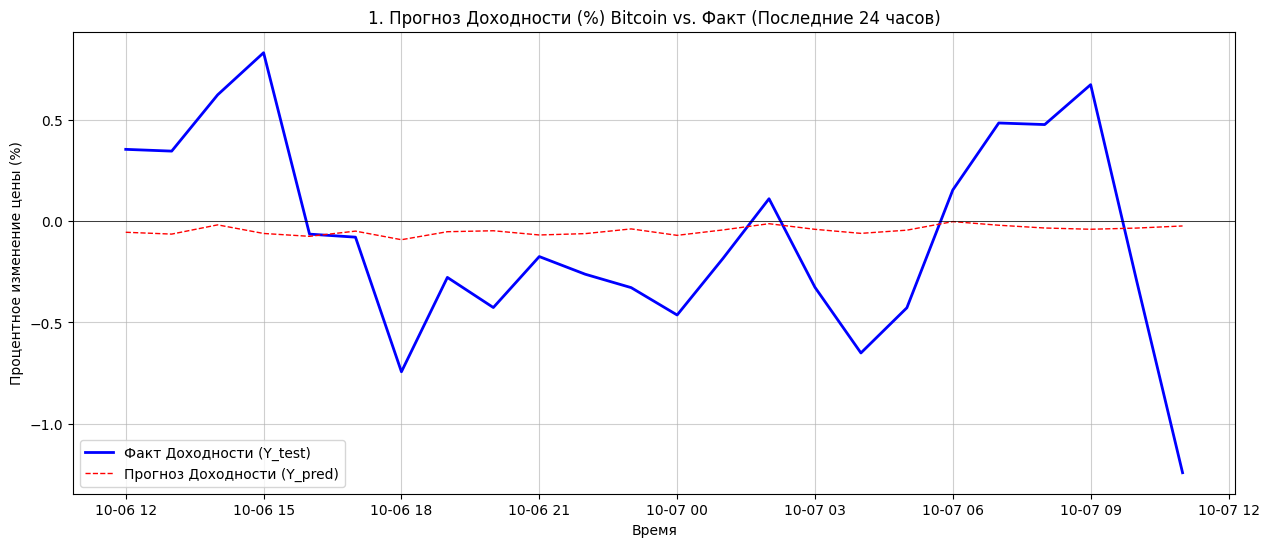

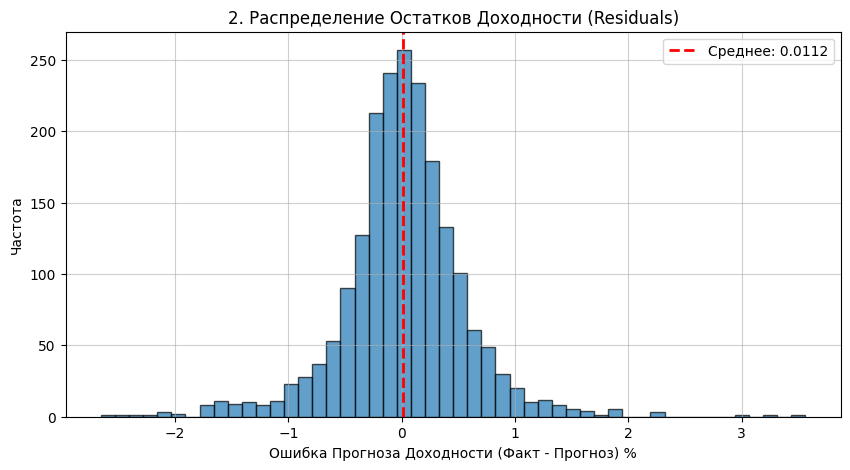

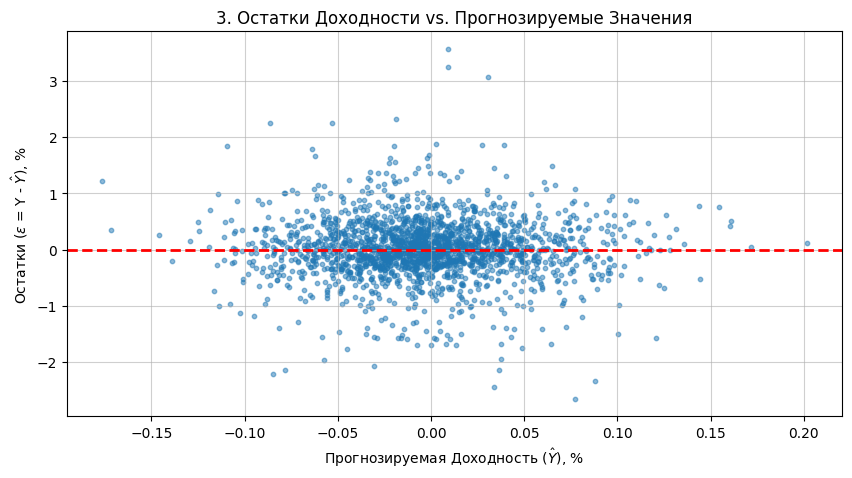

In [11]:
# --- ФУНКЦИИ ВИЗУАЛИЗАЦИИ ---

def plot_model_diagnostics(Y_test, Y_pred):
    """Строит три графика, фокусируясь на доходности."""
    
    residuals = Y_test - Y_pred

    # ----------------------------------------
    # 1. График: Прогноз Доходности vs. Факт (Zoom на последних 24 точках)
    # ----------------------------------------
    plt.figure(figsize=(15, 6))
    N = 24 # Последние 24 наблюдения (сутки)
    Y_test_subset = Y_test.tail(N)
    Y_pred_subset = Y_pred[-N:]
    time_index = Y_test_subset.index
    
    plt.plot(time_index, Y_test_subset, label='Факт Доходности (Y_test)', color='blue', linewidth=2)
    plt.plot(time_index, Y_pred_subset, label='Прогноз Доходности (Y_pred)', color='red', linestyle='--', linewidth=1)
    
    # Горизонтальная линия на 0%
    plt.axhline(0, color='black', linestyle='-', linewidth=0.5) 
    
    plt.title(f'1. Прогноз Доходности (%) Bitcoin vs. Факт (Последние {N} часов)')
    plt.xlabel('Время')
    plt.ylabel('Процентное изменение цены (%)')
    plt.legend()
    plt.grid(True, alpha=0.6)
    plt.show()

    # ----------------------------------------
    # 2. Гистограмма Остатков 
    # ----------------------------------------
    plt.figure(figsize=(10, 5))
    plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
    mean_res = np.mean(residuals)
    plt.axvline(mean_res, color='red', linestyle='dashed', linewidth=2, label=f'Среднее: {mean_res:.4f}')
    
    plt.title('2. Распределение Остатков Доходности (Residuals)')
    plt.xlabel('Ошибка Прогноза Доходности (Факт - Прогноз) %')
    plt.ylabel('Частота')
    plt.legend()
    plt.grid(True, alpha=0.6)
    plt.show()
    
    # ----------------------------------------
    # 3. Диаграмма Рассеяния Остатков
    # ----------------------------------------
    plt.figure(figsize=(10, 5))
    plt.scatter(Y_pred, residuals, alpha=0.5, s=10)
    plt.axhline(0, color='red', linestyle='--', linewidth=2)
    
    plt.title('3. Остатки Доходности vs. Прогнозируемые Значения')
    plt.xlabel('Прогнозируемая Доходность ($\hat{Y}$), %')
    plt.ylabel('Остатки ($\epsilon$ = Y - $\hat{Y}$), %')
    plt.grid(True, alpha=0.6)
    plt.show()

# --- ЗАПУСК ВИЗУАЛИЗАЦИИ (нужно заменить Y_test_data и Y_pred_data) ---
if 'Y_test_data' in locals():
    plot_model_diagnostics(Y_test_data, Y_pred_data)